In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [5]:
# Read data
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [6]:
#@title Preprocess the data

# Read data
df = pd.read_csv('compas-scores-two-years.csv')

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['days_b_screening_arrest'].notnull()]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race'])
df['duration'] = df['end'] - df['start']

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Female', 'sex_Male', 'age', 'race_African-American', 'race_Caucasian',
                  'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count',
                  'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest','c_days_from_compas', 'duration']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head(20)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,recidivism_within_2_years,COMPASS_determination,sex_Female,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other,duration
0,69,0,0,0,0,-1.0,1.0,0,0,0,1,0,0,0,0,1,327
1,34,0,0,0,0,-1.0,1.0,1,0,0,1,1,0,0,0,0,150
2,24,0,0,1,4,-1.0,1.0,1,0,0,1,1,0,0,0,0,63
5,44,0,0,0,0,0.0,0.0,0,0,0,1,0,0,0,0,1,852
6,41,0,0,0,14,-1.0,1.0,1,1,0,1,0,1,0,0,0,35
7,43,0,0,0,3,-1.0,1.0,0,0,0,1,0,0,0,0,1,265
8,39,0,0,0,0,-1.0,1.0,0,0,1,0,0,1,0,0,0,745
9,21,0,0,0,1,428.0,308.0,1,0,0,1,0,1,0,0,0,428
10,27,0,0,0,0,-1.0,1.0,0,0,0,1,0,1,0,0,0,857
11,23,0,0,0,3,0.0,0.0,1,1,0,1,1,0,0,0,0,124


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907 entries, 0 to 7213
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        6907 non-null   int64  
 1   juv_fel_count              6907 non-null   int64  
 2   juv_misd_count             6907 non-null   int64  
 3   juv_other_count            6907 non-null   int64  
 4   priors_count               6907 non-null   int64  
 5   days_b_screening_arrest    6907 non-null   float64
 6   c_days_from_compas         6907 non-null   float64
 7   recidivism_within_2_years  6907 non-null   int64  
 8   COMPASS_determination      6907 non-null   int64  
 9   sex_Female                 6907 non-null   uint8  
 10  sex_Male                   6907 non-null   uint8  
 11  race_African-American      6907 non-null   uint8  
 12  race_Caucasian             6907 non-null   uint8  
 13  race_Hispanic              6907 non-null   uint8

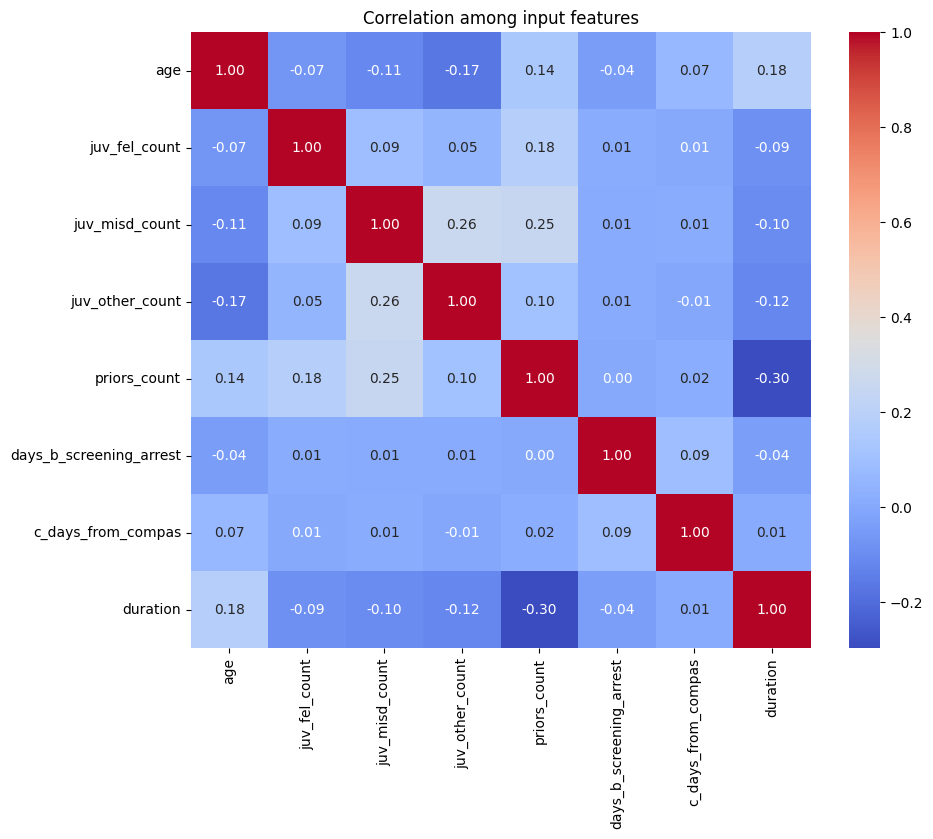

In [8]:
#@title Analyze data before training
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.drop(columns = ['recidivism_within_2_years', 'COMPASS_determination'])
corr_matrix = numeric_df.corr()

# corrplot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation among input features')
plt.show()

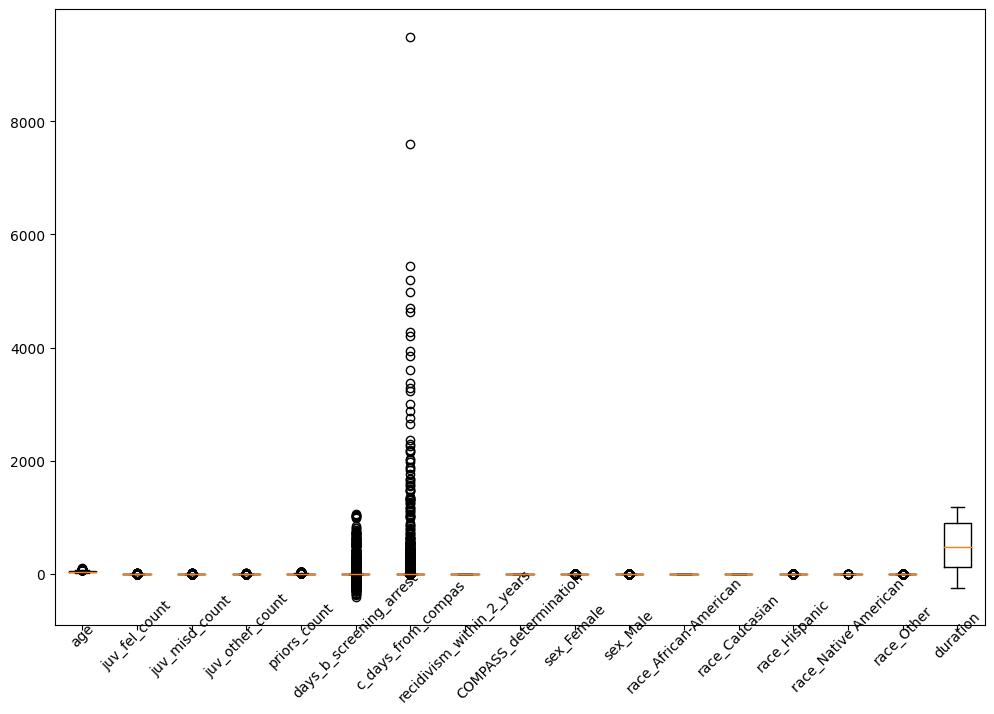

In [9]:
# Check for outliers
fig = plt.figure(figsize =(12, 8))
# Creating plot
plt.boxplot(df, labels=df.columns)
# Rotate x-axis labels by 45 degrees vertically
plt.xticks(rotation=45, va='center')
# show plot
plt.show()

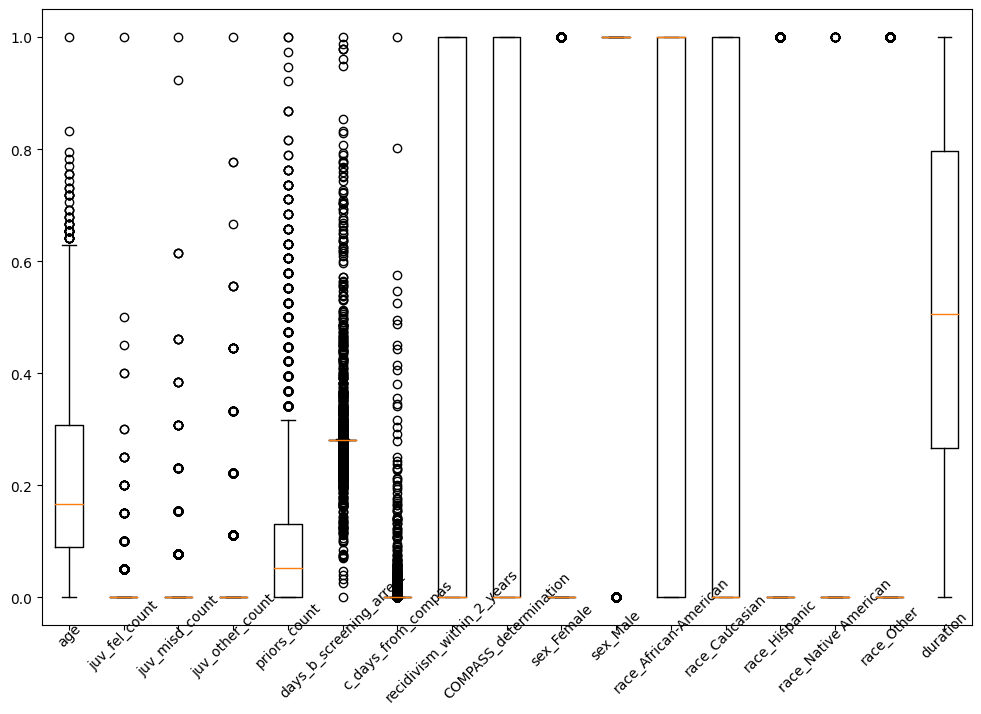

In [10]:
# Normalize the data
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Specify columns to normalize
columns_to_normalize = numeric_df.columns

# Fit and transform the specified columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Check for outliers in the normalized data
fig = plt.figure(figsize=(12, 8))
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, va='center')  # Ensure correct x-axis labels
plt.show()

In [12]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

In [13]:
#@title Final selection: DNN
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store evaluation metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
conf_matrices = []

# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

# Create and compile the model
model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Perform K-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
for train_index, val_index in skf.split(train_data, train_labels):
    X_train_fold, X_val_fold = train_data.iloc[train_index], train_data.iloc[val_index]
    y_train_fold, y_val_fold = train_labels.iloc[train_index], train_labels.iloc[val_index]

    # Train the model
    history = model.fit(X_train_fold.values, y_train_fold.values, epochs=16, batch_size=32, validation_data=(X_val_fold.values, y_val_fold.values))

    # Extract training and validation loss and accuracy from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Append the values to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_data.values, test_labels.values)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Predict labels for test data
    test_predictions = model.predict(test_data.values)
    test_predictions_rounded = test_predictions.round()

    # Calculate precision and recall
    precision = precision_score(test_labels.values, test_predictions_rounded)
    recall = recall_score(test_labels.values, test_predictions_rounded)
    test_precisions.append(precision)
    test_recalls.append(recall)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_labels.values, test_predictions_rounded)
    conf_matrices.append(conf_matrix)

# Calculate average training and validation loss and accuracy across all folds
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)
avg_train_acc = np.mean(train_accuracies, axis=0)
avg_val_acc = np.mean(val_accuracies, axis=0)

# Calculate average evaluation metrics across all folds
avg_test_loss = sum(test_losses) / num_folds
avg_test_accuracy = sum(test_accuracies) / num_folds
avg_test_precision = sum(test_precisions) / num_folds
avg_test_recall = sum(test_recalls) / num_folds


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               3200      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 14551 (56.84 KB)
Trainable params: 14551 (56.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/16
139/139 [==============================] - 3s 11ms/step - loss: 0.5845 - accuracy: 0.6964 - val_loss: 0.5242 - val_accuracy: 0.7385
Epoch 2/1

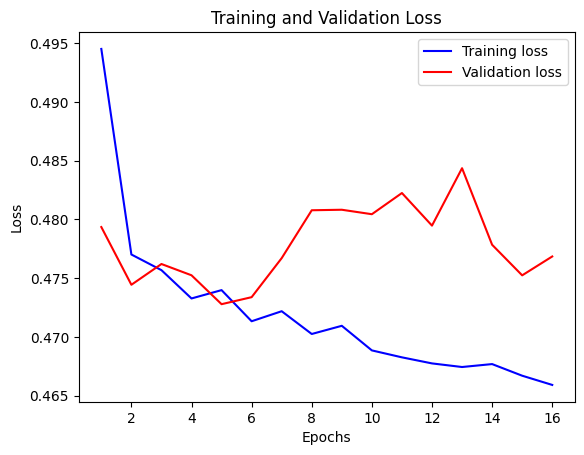

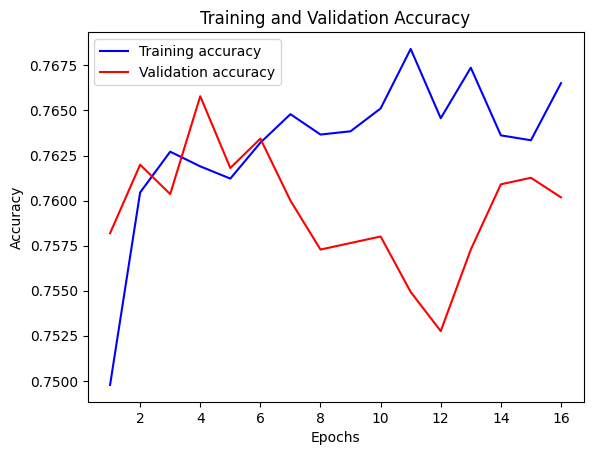

In [14]:
# Plot learning curve
epochs = range(1, len(avg_train_loss) + 1)
plt.plot(epochs, avg_train_loss, 'b', label='Training loss')
plt.plot(epochs, avg_val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, avg_train_acc, 'b', label='Training accuracy')
plt.plot(epochs, avg_val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# Test metrics
print("Average Training Loss:", sum(avg_train_loss)/len(epochs))
print("Average Validation Loss:", sum(avg_val_loss)/len(epochs))
print("Average Test Loss:", avg_test_loss)
print('\n')
print("Average Training Accuracy:", sum(avg_train_acc)/len(epochs))
print("Average Validation Accuracy:", sum(avg_val_acc)/len(epochs))
print("Average Test Accuracy:", avg_test_accuracy)
print('\n')
print("Average Test Precision:", avg_test_precision)
print("Average Test Recall:", avg_test_recall)

Average Training Loss: 0.4719885166734457
Average Validation Loss: 0.47788847051560884
Average Test Loss: 0.5173372864723206


Average Training Accuracy: 0.763158942759037
Average Validation Accuracy: 0.7594909645617008
Average Test Accuracy: 0.748914635181427


Average Test Precision: 0.7573089151992447
Average Test Recall: 0.6834621329211747


Average Confusion Matrix:
[[592 142]
 [204 442]]


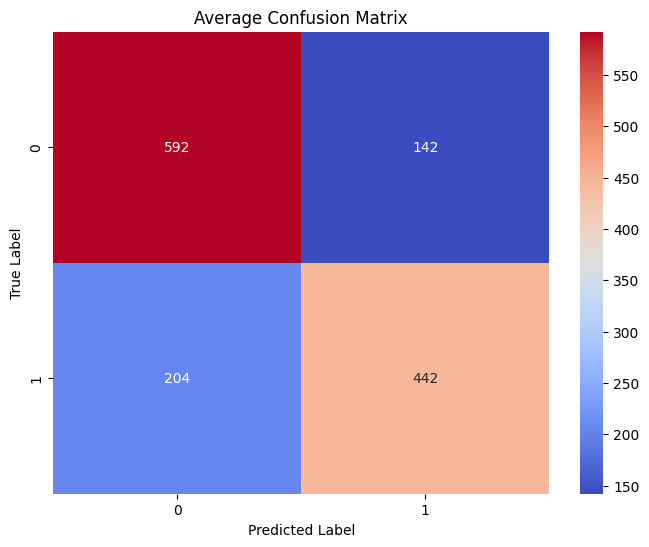

In [16]:
# Calculate and print average confusion matrix
avg_conf_matrix = sum(conf_matrices) // num_folds
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Plot average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()